# Image Augmentation

In order to create more balanced images, we perform some image augmentation to create additional images.

We need to be a bit conservative in our augmentation :
- Conservative rotations (±15° max)
- Subtle color adjustments
- Preserved anatomical structures
- Gaussian blur for different focus conditions

In [1]:
! pip install torch torchvision pillow matplotlib numpy

In [2]:
import os
import cv2
from matplotlib import pyplot as plt
def display_images(image_filenames:list[str], title="Image DataSet", col_count = 10):
    plt.suptitle(title, fontsize=10)
    img_count = len(image_filenames)
    plt.figure(figsize=(15, 15))
    for i in range(1, img_count+1):
        plt.subplot(5, col_count, i)
        image_path=image_filenames[i-1]
        image_name=os.path.basename(image_path)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, aspect="auto")
        plt.title(f"{image_name}",fontsize=9)
        plt.axis(False)
    plt.show();

In [3]:
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
from pathlib import Path

class ODIRAugmentor:
    """Augmentor specifically for ODIR-2019 eye fundus images"""
    
    def __init__(self, output_dir):
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # Define specific augmentations suitable for medical eye images
        self.augmentations = {
            'flip': transforms.RandomHorizontalFlip(p=1.0),
            'rotate': transforms.RandomRotation(degrees=(-15, 15)),
            'brightness': transforms.ColorJitter(brightness=0.2),
            'contrast': transforms.ColorJitter(contrast=0.2),
            'color': transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            'blur': transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
        }
        
        # Combinations that work well for fundus images
        self.presets = {
            'basic': ['flip', 'rotate'],
            'color_variation': ['brightness', 'contrast', 'rotate'],
            'geometric': ['flip'],
            'full': ['flip', 'rotate', 'color','brightness','contrast','blur'],
        }
    
    def create_augmentations(self, image_path, num_images=8, preset='full'):
        """
        Create augmented images using a preset combination
        """
        image = Image.open(image_path).convert('RGB')
        original_name = Path(image_path).stem
        original_ext = Path(image_path).suffix
        
        # Get augmentation list for preset
        aug_list = self.presets[preset]
        
        output_paths=[]
        # Save original
        original_filename=f"{original_name}{original_ext}"
        original_path = os.path.join(self.output_dir, original_filename)
        image.save(original_path)
        output_paths.append({"path":original_path,"augmentations":"original","filename":original_filename})
        # Create transformations
        for i in range(num_images):
            transform_list = []
            
            # Randomly select 2-3 augmentations from the preset
            num_augs = np.random.randint(2, min(4, len(aug_list) + 1))
            selected_augs = np.random.choice(aug_list, num_augs, replace=False)
            
            for aug_name in selected_augs:
                transform_list.append(self.augmentations[aug_name])
                        
            # Create transform
            transform = transforms.Compose(transform_list)
            
            # Apply and save
            augmented = transform(image)
            output_filename = f"{original_name}_a_{i+1:02d}{original_ext}"
            output_path = os.path.join(
                self.output_dir, 
                output_filename
            )
            augmented.save(output_path)
            selected_augs = " ".join(selected_augs)
            output_paths.append({"filename":output_filename,"augmentations":f"{selected_augs}","path":output_path})
        return output_paths

<Figure size 640x480 with 0 Axes>

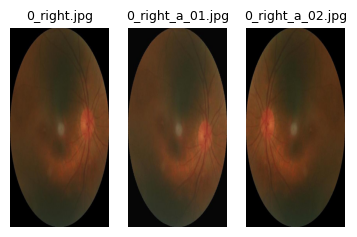

,path,augmentations,filename
0,ODIR-2019/augmented_512_images/0_right.jpg,original,0_right.jpg
1,ODIR-2019/augmented_512_images/0_right_a_01.jpg,rotate brightness contrast,0_right_a_01.jpg
2,ODIR-2019/augmented_512_images/0_right_a_02.jpg,color flip,0_right_a_02.jpg


In [4]:
import pandas as pd
input_folder="ODIR-2019/processed_512_images"
output_folder="ODIR-2019/augmented_512_images"
input_image=f"{input_folder}/0_right.jpg"
os.makedirs(output_folder, exist_ok=True)
augmentor = ODIRAugmentor(output_dir=output_folder)
images=augmentor.create_augmentations(image_path=input_image, num_images=2)
image_paths = [k["path"] for k in images  ]
display_images(image_paths,"augmented images")
images_df = pd.DataFrame(images)
images_df

We can see that we managed to augment our image with additional 8 images

Next we need to adjust for each category in our training dataset to create a balanced dataset and update our dataset

From our EDA we have the following 
```text
Train Data Set Output
label
N    2112
D    1201
O     511
G     211
A     199
C     199
M     172
H      96
```
We aim to make each category more or less close to Normal category. Hence, we can calculate a ratio of augmented data

Ratio for D = Size of N / Size of D = 2112 / 1201 = 1.75 for each image in D we need another image, capped at 2112

Hence our algorithm will first find extra image needed for each image in a category and then generate augmentation for it 
```python
max_count = largest number of images count for all labels
for each label:
    missing_images_count = max_count - no_of_images_in_current_label
    label_augmented_count = int (max_count/no_of_images_in_current_label) 
    for each image in curent label:
        if missing_images_count greater or equal label_augmented_count:
            n =label_augmented_count
        else
            n = missing_images_count
        generate n augmented images for current image
        reduce missing_images_count by n
```


In [5]:
import pandas as pd
input_folder="ODIR-2019/processed_512_images"
output_folder="ODIR-2019/augmented_512_images"
input_image=f"{input_folder}/0_right.jpg"
augmentor = ODIRAugmentor(output_dir=output_folder)
train_df = pd.read_csv('ODIR-2019/results/01_eda_train_df.csv')
vc=train_df['label'].value_counts()
max_value =vc.max()
max_label = vc.idxmax()
print("Largest label is ", max_label, " of ", max_value, "images")
all_possible_labels = train_df['label'].unique()
rows=[]
for label in all_possible_labels:
    label_count = vc[label]
    missing_count = max_value - label_count
    label_aug_count = max_value//label_count
    original = train_df['label']==label
    if missing_count>0:
        print("- ",label,"has ",label_count, "images, augment ", missing_count, " images ")
    else:
        print("- ",label,"has ",label_count, "images" )
    for row in train_df[original].itertuples():
        if missing_count>= label_aug_count:
            augment_count = label_aug_count
        else:
            augment_count = missing_count
        input_image=f"{input_folder}/{row.filename}"
        outputs=augmentor.create_augmentations(input_image, num_images=augment_count)
        for output in outputs:
            rows.append({
                    "filename":output["filename"],
                    "label_detail": row.label_detail,
                    "keywords":row.keywords,
                    "label":row.label,
                    "augmentations":output["augmentations"]
                })
        missing_count -= augment_count
aug_df = pd.DataFrame(rows)
aug_df.to_csv('ODIR-2019/results/03_aug_train_512_df.csv', index=False)
                 


Largest label is  N  of  2252 images
-  N has  2252 images
-  G has  225 images, augment  2027  images 
-  D has  1281 images, augment  971  images 
-  O has  545 images, augment  1707  images 
-  C has  213 images, augment  2039  images 
-  M has  183 images, augment  2069  images 
-  H has  102 images, augment  2150  images 
-  A has  213 images, augment  2039  images 


In [6]:
aug_df = pd.read_csv('ODIR-2019/results/03_aug_train_512_df.csv')
aug_df.head(n=20)

,filename,label_detail,keywords,label,augmentations
0,329_right.jpg,normal,normal fundus,N,original
1,3350_right.jpg,normal,normal fundus,N,original
2,2417_left.jpg,normal,normal fundus,N,original
3,3313_left.jpg,normal,normal fundus,N,original
4,2540_right.jpg,normal,normal fundus,N,original
5,503_right.jpg,normal,normal fundus,N,original
6,2896_right.jpg,normal,normal fundus,N,original
7,2914_right.jpg,normal,normal fundus,N,original
8,160_left.jpg,normal,normal fundus,N,original
9,2361_right.jpg,normal,normal fundus,N,original


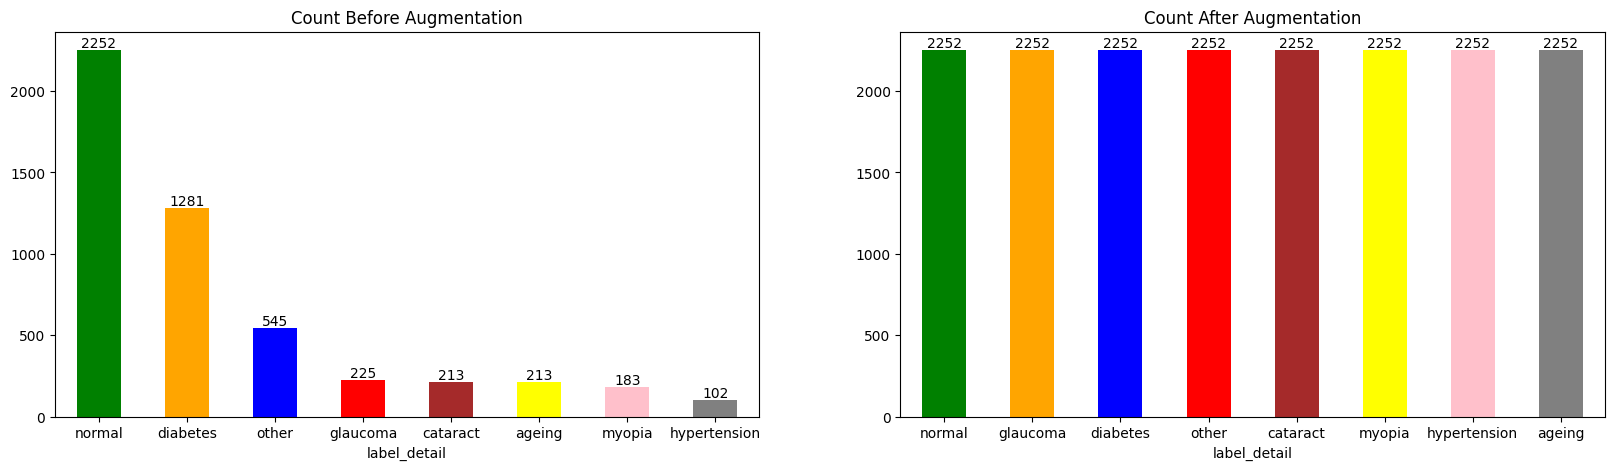

In [7]:
counts=train_df['label_detail'].value_counts()
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
counts.plot.bar(color=['green','orange','blue','red','brown','yellow','pink','gray'])
plt.title("Count Before Augmentation")
plt.xticks(rotation=0) # Keeps x-axis labels horizontal
# Optional: Add value labels on top of the bars
for index, value in enumerate(counts):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

counts=aug_df['label_detail'].value_counts()
plt.subplot(1,2,2)
counts.plot.bar(color=['green','orange','blue','red','brown','yellow','pink','gray'])
plt.title("Count After Augmentation")
plt.xticks(rotation=0) # Keeps x-axis labels horizontal
# Optional: Add value labels on top of the bars
for index, value in enumerate(counts):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

We have created new dataset ODIR-2019/results/03_aug_train_512_df.csv and images for augmented dataset at ODIR-2019/augmented_512_images